In [9]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.stats import norm
import seaborn as sns
import scipy.spatial.distance as dist
np.random.seed(12345678)  # for reproducibility, set random seed

# Read in data
df = pd.read_csv('../output.csv')

nvox = 64*64*48 # assume number of voxels per bin
df['weighted'] = df['synapses']/df['unmasked']*nvox

xvals = df['cx'].unique()
yvals = df['cy'].unique()
zvals = df['cz'].unique()

# Get rid of the blank edges
left = 0;
right = len(xvals);
top = 0;
bottom = len(yvals);
for z in zvals:
    this_z = df[df['cz']==z]
    
    # X direction
    xhist, bin_edges = np.histogram(this_z['cx'], weights = this_z['unmasked']/(nvox*len(yvals)), bins=len(xvals))
    
    left = max(left, np.argmax(xhist>0.5))
    right = min(right, len(xvals)-np.argmax(xhist[::-1]>0.5))
    
    # Y direction
    yhist, bin_edges = np.histogram(this_z['cy'], weights = this_z['unmasked']/(nvox*len(xvals)), bins=len(yvals))
    
    top = max(top, np.argmax(yhist>0.5))
    bottom = min(bottom, len(yvals)-np.argmax(yhist[::-1]>0.5))

# Copy new dataset without edges
df2 = df.copy()
for z in zvals:
    df2.drop(df2.index[(df2['cx']<xvals[left]) | (df2['cx']>=xvals[right])], inplace=True)
    df2.drop(df2.index[(df2['cy']<yvals[top]) | (df2['cy']>=yvals[bottom])], inplace=True)

xvals = df2['cx'].unique()
yvals = df2['cy'].unique()
zvals = df2['cz'].unique()


### Independence

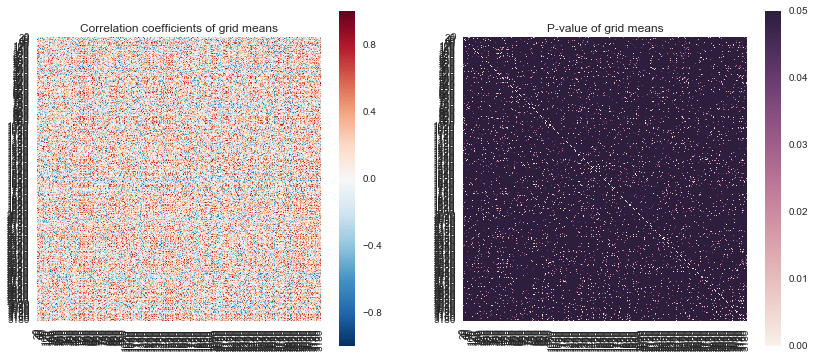

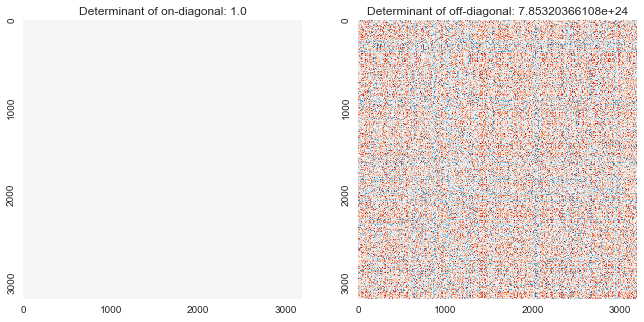

Ratio of on- and off-diagonal determinants: 1.27336567744e-25


In [10]:
Zvalue = np.unique(df2['cz'])
minlen = 100000

for i in Zvalue:
    temp = len(df2[df2['cz'] == i])
    if temp < minlen:
        minlen = temp

for i in Zvalue:
    if i == 55:
        temp = df2[df2['cz'] == i]['weighted']
        out = np.random.choice(temp, minlen)
    else :
        temp = df2[df2['cz'] == i]['weighted']
        sample = np.random.choice(temp, minlen)
        out = np.column_stack((out, sample))
        
corr = np.corrcoef(out)
pval = dist.squareform(dist.pdist(out, lambda x, y: ss.pearsonr(x, y)[1]))

plt.figure(figsize=(14, 6))
plt.subplot(121)
sns.heatmap(corr, square=True, xticklabels=20, yticklabels=20)
plt.title('Correlation coefficients of grid means')
plt.subplot(122)
sns.heatmap(pval, square=True, vmin=0, vmax=0.05, xticklabels=20, yticklabels=20)
plt.title('P-value of grid means')
plt.show()

diag = corr.diagonal() * np.eye(corr.shape[0])
hollow = corr - diag
d_det = np.linalg.det(diag)
h_det = np.linalg.det(hollow)

plt.figure(figsize=(11, 8))
plt.subplot(121)
sns.heatmap(diag, vmin=np.min(corr), vmax=np.max(corr), cbar=False, square=True, xticklabels=1000, yticklabels=1000)
plt.title('Determinant of on-diagonal: ' + str(d_det))
plt.subplot(122)
sns.heatmap(hollow, vmin=np.min(corr), vmax=np.max(corr), cbar=False, square=True, xticklabels=1000, yticklabels=1000)
plt.title('Determinant of off-diagonal: ' + str(h_det))
plt.show()

print "Ratio of on- and off-diagonal determinants: " + str(d_det / h_det)

### Identical

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Fitting and evaluating model with 1 clusters.
Fitting and evaluating model with 2 clusters.
Fitting and evaluating model with 3 clusters.
Fitting and evaluating model with 4 clusters.
Fitting and evaluating model with 5 clusters.
Fitting and evaluating model with 6 clusters.
Fitting and evaluating model with 7 clusters.
Fitting and evaluating model with 8 clusters.
Fitting and evaluating model with 9 clusters.
Fitting and evaluating model with 10 clusters.
Fitting and evaluating model with 11 clusters.
Fitting and evaluating model with 12 clusters.
Fitting and evaluating model with 13 clusters.
Fitting and evaluating model with 14 clusters.
Fitting and evaluating model with 15 clusters.


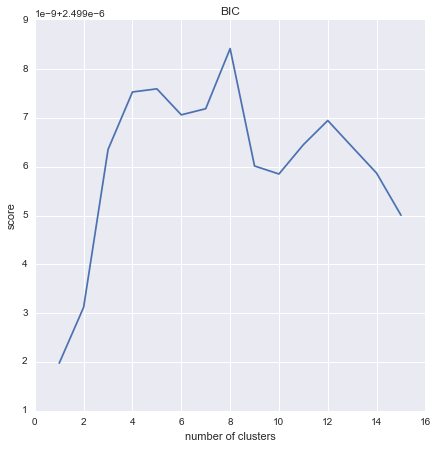

[ 399843.91337054  399660.89559448  399145.45033334  398957.93423473
  398947.75625099  399032.47125435  399012.50076993  398816.55051807
  399199.34666183  399225.48395154  399129.91200188  399051.01611105
  399137.18119979  399222.73659043  399360.21413495]


In [7]:
import sklearn.mixture
i = np.linspace(1, 15, 15, dtype = 'int')
print i
bic = np.array(())
for idx in i:
    print "Fitting and evaluating model with " + str(idx) + " clusters."
    gmm = sklearn.mixture.GMM(n_components=idx, n_iter=1000, covariance_type = 'diag')
    gmm.fit(out)
    bic = np.append(bic, gmm.bic(out))
plt.figure(figsize=(7, 7))
plt.plot(i, 1.0/bic)
plt.title('BIC')
plt.ylabel('score')
plt.xlabel('number of clusters')
plt.show()
print bic